# Project: Evaluation of neural network architectures on MNIST datasets

## Group Members : Yidong HUANG, Simon ROBER, Marck-Edward KEMEH

### ABOUT
The MNIST dataset is a large database of handwritten digits used in many forms of image processing.
This dataset contains 60,000 training images and 10,000 test images. Our aim is to design some neural 
networks that can recognise these hand-written digits. our projects will be based on two different networks
for this task.                   

In [20]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

We begin by splitting the MNIST dataset into two. A set for training and another for testing.
We then normalize the test set and training set by dividing with 255 so that the values can be between 0 and 1.
Because we will be working with convolutional neural network, we need to change the original shape of the MNIST dataset which is (60000, 28, 28) to that of the convolutional neural network (60000, 28, 28, 1).
This section is just to prepare our dataset for the network.

In [3]:
# dividing dataset into train and test set, also reshaping dataset to fit input of network
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0
print('shape before adding dimension is :' ,x_train.shape)
x_train, x_test = np.expand_dims(x_train, axis= -1), np.expand_dims(x_test, axis = -1)
x_train = x_train.reshape(x_train.shape[0],28,28,1)
x_test = x_test.reshape(x_test.shape[0],28,28,1)
print ('shape after adding dimension is :' ,x_train.shape)

shape before adding dimension is : (60000, 28, 28)
shape after adding dimension is : (60000, 28, 28, 1)


### First Model
Our first model is a simple network definition which will be used to train the neural network.
Our input shape has to match that of the train set as did above and we are using relu as activation


In [4]:
#first simple model

model1 = keras.Sequential()
model1.add(layers.Input(shape = (28,28,1)))
model1.add(layers.Conv2D(32, (3,3), padding ='valid', activation = 'relu'))
model1.add(layers.MaxPool2D((2,2), (2, 2)))
model1.add(layers.Flatten())
model1.add(layers.Dense(10, activation = 'softmax'))
model1.summary()
model1.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


We now test using our test set against the model we trained to determine if the model actually learned to recognise the digits. For each epoch, we can see the loss rate is decreasing which tells us the model is actually improving on the learning.

In [5]:
#training
model1.fit(x_train, y_train, epochs = 4)

Epoch 1/4
60000/60000 [==============================] - 28s 460us/sample - loss: 0.2086 - acc: 0.9406
Epoch 2/4
60000/60000 [==============================] - 27s 454us/sample - loss: 0.0792 - acc: 0.9773
Epoch 3/4
60000/60000 [==============================] - 25s 423us/sample - loss: 0.0596 - acc: 0.9825
Epoch 4/4
60000/60000 [==============================] - 26s 429us/sample - loss: 0.0485 - acc: 0.9849


Next we use the accuracy to determine how well our classifier classifies on the test set to make sure we are not over fitting.


In [6]:
def accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print("test loss is : {0} - test accuracy is : {1}".format(test_loss, test_acc))

    
# Accuracy:
accuracy(model1, x_test, y_test)

10000/10000 [==============================] - 2s 159us/sample - loss: 0.0543 - acc: 0.9810
test loss is : 0.05433121092445217 - test accuracy is : 0.9810000061988831


#### ROC
We implement the ROC curve and Precision-Recall curve to view the performance of our model on the test set

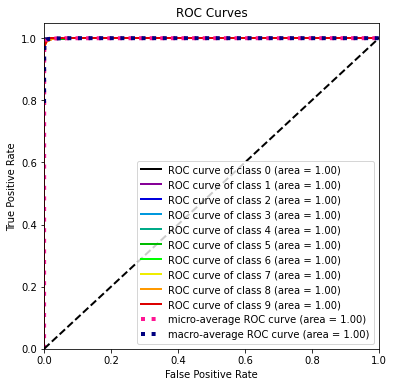

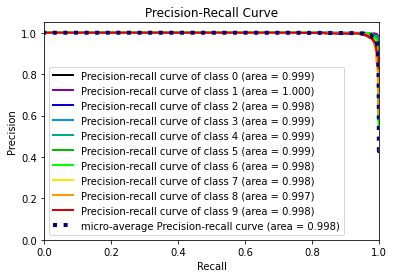

In [32]:
def roc_curve(model, x_test, y_test):
    y_true = y_test # Given ground truth
    y_probas = model.predict(x_test)
    skplt.metrics.plot_roc(y_true, y_probas, figsize=(6,6))     # https://scikit-plot.readthedocs.io/en/stable/metrics.html
    plt.show()

# ROC:
roc_curve(model1, x_test, y_test)

def precision_recall(model, x_test, y_test):
    y_probas = model.predict(x_test)
    skplt.metrics.plot_precision_recall(y_test, y_probas)
    plt.show()
    
# Precision-Recall:
precision_recall(model1, x_test, y_test)

**TODO: interpret results of Roc Curve, Precision recall!!! **

### Second Model
Below is our second model which follows LeNet architecture and has an input shape of (32, 32, 1). Again we define the network, train it and see how it performs in terms of accuracy, Roc curve and Precision-Recall curve.

In [13]:
model2 = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])


model2.summary()
model2.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2.fit(x_train, y_train, epochs = 4)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 6)         60        
_________________________________________________________________
average_pooling2d_8 (Average (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 16)        880       
_________________________________________________________________
average_pooling2d_9 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_14 (Dense)             (None, 84)               

10000/10000 [==============================] - 2s 207us/sample - loss: 0.0364 - acc: 0.9875
test loss is : 0.036436897031439 - test accuracy is : 0.987500011920929


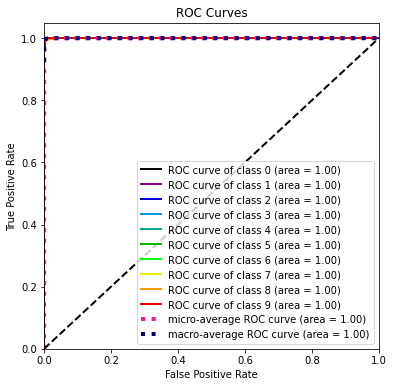

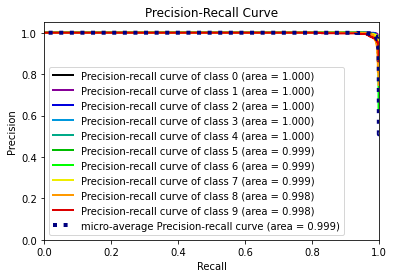

In [14]:
accuracy(model2, x_test, y_test)
roc_curve(model2, x_test, y_test)
precision_recall(model2, x_test, y_test)

**TODO: interpret results of Roc Curve, Precision recall!!! + Add comments to the model.**

As you can see we now use all the previous defined functions to build the second model.
These first two model were our first experience playing around with Keras and with the CNN. In the next section we will look into the parameters in a more systematic maner. We will build on the second model described above and alter one parameter everytime

#### Comparison model one and model two 

#### Learning Rate

By default the learning rate of the model with Adam is 0.001. Lets increase and decease the learning rate slightly to see what the effect is.

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 26, 26, 6)         60        
_________________________________________________________________
average_pooling2d_10 (Averag (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 11, 11, 16)        880       
_________________________________________________________________
average_pooling2d_11 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_17 (Dense)             (None, 84)               

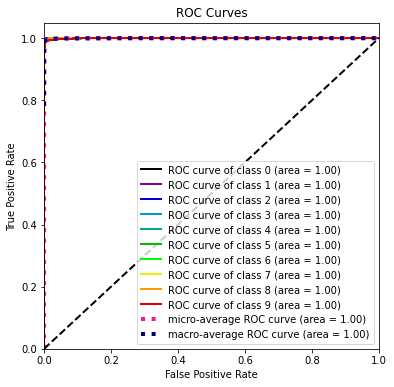

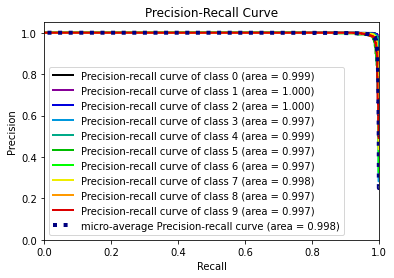

In [15]:
model2_increase_lr = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])

model2_increase_lr.summary()
model2_increase_lr.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2_increase_lr.fit(x_train, y_train, epochs = 4)

accuracy(model2_increase_lr, x_test, y_test)
roc_curve(model2_increase_lr, x_test, y_test)
precision_recall(model2_increase_lr, x_test, y_test)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 26, 6)         60        
_________________________________________________________________
average_pooling2d_12 (Averag (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 11, 11, 16)        880       
_________________________________________________________________
average_pooling2d_13 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_20 (Dense)             (None, 84)               

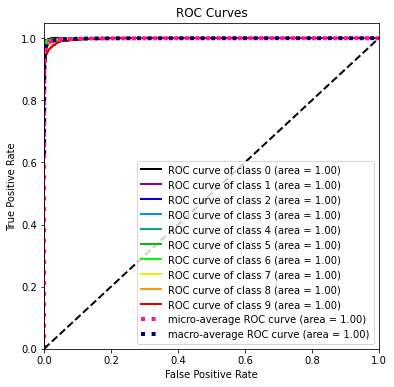

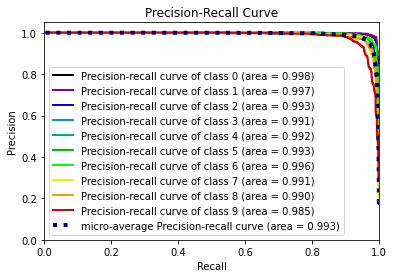

In [16]:
model2_decrease_lr = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])

model2_decrease_lr.summary()
model2_decrease_lr.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

model2_decrease_lr.fit(x_train, y_train, epochs = 4)

accuracy(model2_decrease_lr, x_test, y_test)
roc_curve(model2_decrease_lr, x_test, y_test)
precision_recall(model2_decrease_lr, x_test, y_test)

The vanilla second model had an accuracy of about 0.9875. By increasing the learning rate times 10 the accuracy  drops slightly to about 0.9839 . When decreasing the learning rate through a division of 10 the accuracy also drops, but now even worse to about 0.9646 .

Let us take a look at the different curves. The vanilla version had an almost perfect precision-recall curve, where half of the labels were labeled correctly all the time and the other labels 99% of the times. Yet both increasing and decreasing the learning rate deteriorates the good results by serveral percentages. Here again the decreasing model performs worse then the increasing model.

We notice that both alterations decrease the accuracy. This means we have hit the sweet spot! The learning rate cannot be to large nor to small, because ....

#### Batch Size

#### Number of epochs

#### Kernel size

##### In this section, we would like to see the results of kernel sizes on our model. we set the first layer of the network with kernel size of (5, 5) and the second remains same at (3, 3) and we get an accuracy of 0.966 on the test set which is am improvement on the original model. Changing the kernal size of first layer to (6, 6) gives an accuracy of  0.949 and (2, 2) gives an accuracy of 0.951.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 24, 24, 6)         156       
_________________________________________________________________
average_pooling2d_6 (Average (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 16)        880       
_________________________________________________________________
average_pooling2d_7 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_11 (Dense)             (None, 84)               

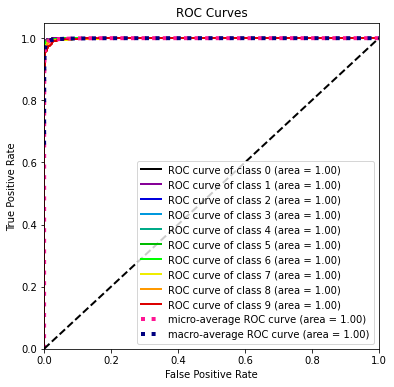

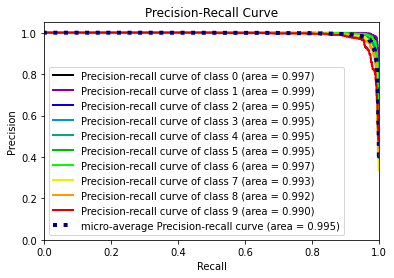

In [12]:
model2_decrease_lr = keras.Sequential()

model2_decrease_lr.add(layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1)))
model2_decrease_lr.add(layers.AveragePooling2D())

model2_decrease_lr.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model2_decrease_lr.add(layers.AveragePooling2D())

model2_decrease_lr.add(layers.Flatten())

model2_decrease_lr.add(layers.Dense(units=120, activation='relu'))

model2_decrease_lr.add(layers.Dense(units=84, activation='relu'))

model2_decrease_lr.add(layers.Dense(units=10, activation = 'softmax'))
model2_decrease_lr.summary()
model2_decrease_lr.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2_decrease_lr.fit(x_train, y_train, epochs = 4)


accuracy(model2_decrease_lr, x_test, y_test)
roc_curve(model2_decrease_lr, x_test, y_test)
precision_recall(model2_decrease_lr, x_test, y_test)